<a href="https://colab.research.google.com/github/Matigol09/curso-series-temporales/blob/master/covidrn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 2.1MB 29.2MB/s 
     |████████████████████████████████| 9.5MB 38.7MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [ ]:
#Unir fuente de datos de manera automática desde Web
covid_data=pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv", sep=",")
mobility_data=pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",sep=",")
covid_data.date=pd.to_datetime(covid_data.date, format="%Y-%m-%d")
mobility_data.date=pd.to_datetime(mobility_data.date, format="%Y-%m-%d")
covid_data['country']=covid_data['location']
mobility_data['country']=mobility_data['country_region']
all_data=pd.merge(covid_data, mobility_data,  how='left', left_on=['country','date'], right_on = ['country','date'])
all_data=all_data.drop(['iso_code','location'],axis=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#selección de datos que vamos a utilizar
selected_data=all_data[['new_cases','new_deaths','residential_percent_change_from_baseline','country','date','sub_region_1']]
selected_data_chile=selected_data[selected_data['country']=='Chile']
selected_data_chile=selected_data_chile[selected_data_chile["sub_region_1"].isna()]

In [ ]:
total_deaths_to_day=selected_data_chile['new_deaths'].sum()

In [ ]:
#datos necesarios para setear la serie de tiempo
selected_data_chile['date']=pd.to_datetime(selected_data_chile['date'])
selected_data_chile=selected_data_chile.set_index('date')
selected_data_chile=selected_data_chile.asfreq('d')
selected_data_chile=selected_data_chile.interpolate()
del selected_data_chile['sub_region_1']


In [ ]:
selected_data=selected_data_chile

In [ ]:
#hay unos datos que salen totalmente de la serie. Se debe por una actualización de datos por parte de la fuente.  
bad_idx = selected_data.index[selected_data['new_deaths']>500]

In [ ]:
selected_data.loc[bad_idx,'new_deaths'] = np.nan
selected_data=selected_data.interpolate()

In [ ]:
maxid=selected_data.index[selected_data['new_deaths']==selected_data['new_deaths'].max()]

In [ ]:
maximo=selected_data.loc[maxid]

In [ ]:
maximo.index

DatetimeIndex(['2020-06-28'], dtype='datetime64[ns]', name='date', freq='D')

In [ ]:
selected_data.head()

,new_cases,new_deaths,residential_percent_change_from_baseline,country
date,,,,
2020-03-04,1.0,0.0,0.0,Chile
2020-03-05,2.0,0.0,0.0,Chile
2020-03-06,1.0,0.0,0.0,Chile
2020-03-07,1.0,0.0,3.0,Chile
2020-03-08,3.0,0.0,1.5,NaN


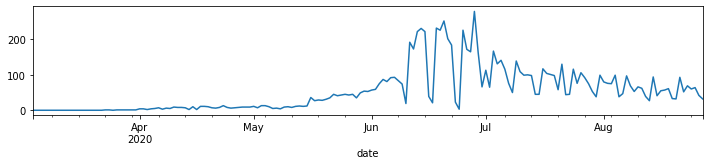

In [ ]:
results = seasonal_decompose(selected_data['new_deaths'])
results.observed.plot(figsize=(12,2))

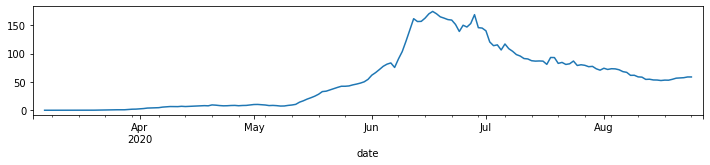

In [ ]:
results.trend.plot(figsize=(12,2))

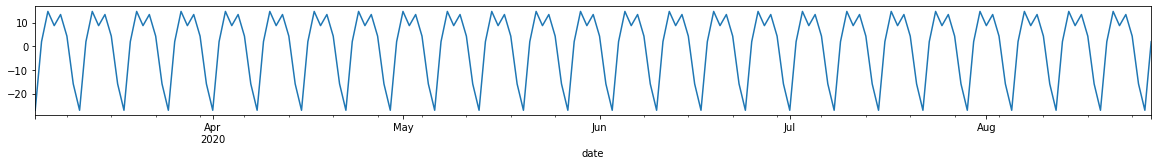

In [ ]:
results.seasonal.plot(figsize=(20,2))

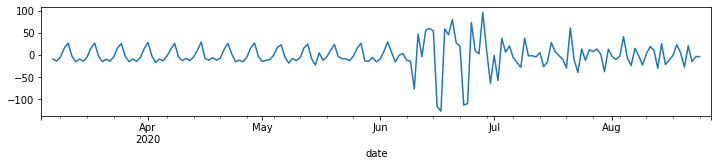

In [ ]:
results.resid.plot(figsize=(12,2))

In [ ]:
del selected_data['country']
del selected_data['new_cases']
del selected_data['residential_percent_change_from_baseline']


In [ ]:
selected_data=selected_data.loc['2020-06-28':]

In [ ]:
train=selected_data.iloc[:round(len(selected_data)*0.9)]

In [ ]:
train.tail(20)

,new_deaths
date,
2020-08-02,76.0
2020-08-03,75.0
2020-08-04,99.0
2020-08-05,38.0
2020-08-06,47.0
2020-08-07,97.0
2020-08-08,69.0
2020-08-09,53.0
2020-08-10,66.0


In [ ]:
test=selected_data.iloc[round(len(selected_data)*0.9):]

In [ ]:
test.head()

,new_deaths
date,
2020-08-22,52.0
2020-08-23,69.0
2020-08-24,60.0
2020-08-25,64.0
2020-08-26,42.0


In [ ]:
len(train),len(test)

(55, 6)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [ ]:
scaled_test

array([[0.09920635],
       [0.16666667],
       [0.13095238],
       [0.1468254 ],
       [0.05952381],
       [0.01984127]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input=7
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(generator,epochs=150)

Epoch 1/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 5/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 6/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 7/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 8/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 9/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 10/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 11/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 12/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 13/150
48/48 [=================

In [ ]:
model.history.history.keys()

dict_keys(['loss'])

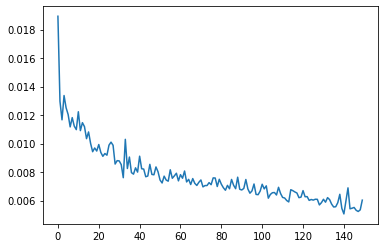

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
first_eval_batch = scaled_train[-7:]

In [ ]:
first_eval_batch

array([[0.05555556],
       [0.11111111],
       [0.11904762],
       [0.13492063],
       [0.02380952],
       [0.01984127],
       [0.26190476]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

array([[0.09288821]], dtype=float32)

In [ ]:
scaled_test

array([[0.09920635],
       [0.16666667],
       [0.13095238],
       [0.1468254 ],
       [0.05952381],
       [0.01984127]])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)


In [ ]:
true_predictions

array([[50.40782797],
       [62.40428245],
       [65.89122391],
       [69.31881613],
       [54.04492432],
       [50.648413  ]])

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


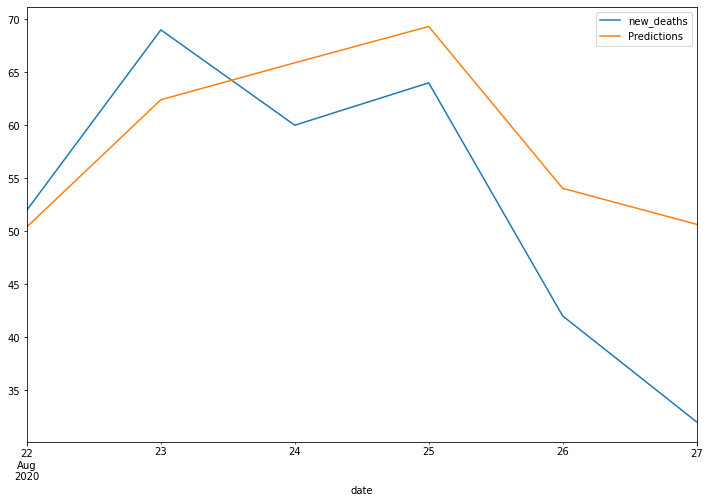

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
test_predictions2 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(50):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions2.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
from datetime import date
today=date.today()
begin=today.strftime("%Y-%m-%d")
forecast=pd.date_range(begin,periods=50, freq='d')
forecast

DatetimeIndex(['2020-08-28', '2020-08-29', '2020-08-30', '2020-08-31',
               '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
               '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
true_predictions2 = scaler.inverse_transform(test_predictions2)

In [ ]:
true_predictions2=scaler.inverse_transform(test_predictions2)
predicts=pd.DataFrame(true_predictions2)
predicts['fecha']=forecast
predicts=predicts.set_index('fecha')
predicts

,0
fecha,
2020-08-28,50.407828
2020-08-29,62.404282
2020-08-30,65.891224
2020-08-31,69.318816
2020-09-01,54.044924
2020-09-02,50.648413
2020-09-03,89.388975
2020-09-04,55.718364
2020-09-05,64.906650


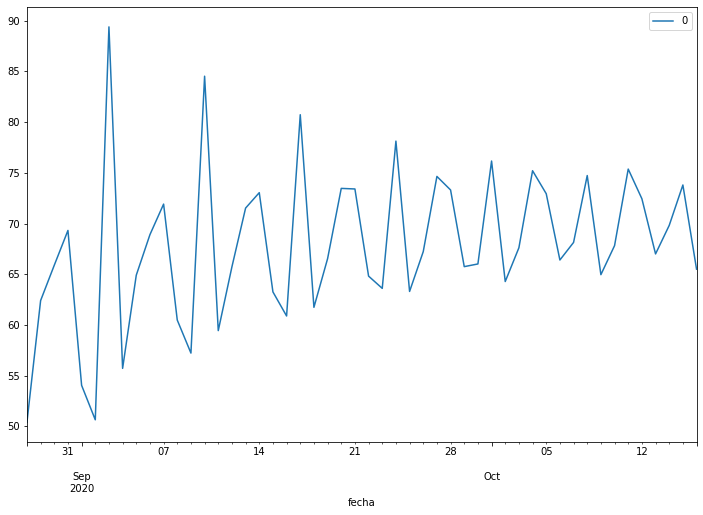

In [ ]:
predicts.plot(figsize=(12,8))

In [ ]:
model.save('deaths_chile_covid_rnn.h5')

In [ ]:
from keras.models import load_model
new_model = load_model('deaths_chile_covid_rnn.h5')